# ECMWF Reanalysis v5 datan avulla tuuli- ja aurinkovoiman tuotannon estimointi

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cdsapi
import matplotlib.pyplot as plt
import seaborn as sns
from windpowerlib import ModelChain, WindTurbine
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Säädatan kutsuminen cds:stä
* 10m tuuli ja auringonsäteily koko Suomen alueelle kahden viikon ajalta
* Yksinkertaisuuden vuoksi valitaan 3 pistettä, joissa tuotanto on suurinta ja lasketaan kokonaistuotanto niiden mukaan

In [24]:
dataset = "reanalysis-era5-single-levels-timeseries"
request = {
    "variable": [
        "surface_pressure",
        "2m_temperature",
        "100m_u_component_of_wind",
        "100m_v_component_of_wind"
    ],
    "location": {"longitude": 25, "latitude": 66}, #(21.5, 62.5 = närpiö) (66, 25 = simo) (64, 23.5 = kalajoki)
    "date": ["2025-10-01/2025-10-14"],
    "data_format": "csv"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2026-02-06 13:34:57,945 WARNING [2025-03-17T00:00:00] Please be aware that the generation of this dataset is using an alternative source for the ERA5 data and may be subject to changes over time (e.g. file format, data file structure, deprecation etc). This dataset should therefore be regarded as “experimental” and is **not recommended for use in a production environment**. 

Notification of changes via this catalogue entry banner and/or in the [Forum](https://forum.ecmwf.int/) will be provided on best efforts.

Notification of changes via this catalogue entry banner and/or in the [Forum](https://forum.ecmwf.int/) will be provided on best efforts.
2026-02-06 13:34:57,949 INFO Request ID is 422ada46-13e9-4c3f-875f-b94ce6bb56b0
INFO:ecmwf.datastores.legacy_client:Request ID is 422ada46-13e9-4c3f-875f-b94ce6bb56b0
2026-02-06 13:34:58,037 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-06 13:35:11,705 INFO status has 

'40f7a3a6e828fb4a55ddbec464e30de8.zip'

# Kalajoen, närpiön ja simon dataframet

In [2]:
df_k = pd.read_csv("kalajoki.zip")
df_k.set_index("valid_time", inplace=True)
#print(df_k.head())

df_n = pd.read_csv("narpio.zip")
df_n.set_index("valid_time", inplace=True)
print(df_n.head())

df_s = pd.read_csv("simo.zip")
df_s.set_index("valid_time", inplace=True)
print(df_s.head())

                         u100      v100        t2m         sp  latitude  \
valid_time                                                                
2025-10-01 00:00:00  0.425766  6.332184  276.29810  103074.89      62.5   
2025-10-01 01:00:00  0.183731  6.486710  276.37332  103073.20      62.5   
2025-10-01 02:00:00  0.119232  6.377823  275.85962  103085.54      62.5   
2025-10-01 03:00:00 -0.168198  6.372909  275.54360  103069.97      62.5   
2025-10-01 04:00:00 -0.467758  6.192230  275.06800  103079.06      62.5   

                     longitude  
valid_time                      
2025-10-01 00:00:00       21.5  
2025-10-01 01:00:00       21.5  
2025-10-01 02:00:00       21.5  
2025-10-01 03:00:00       21.5  
2025-10-01 04:00:00       21.5  
                         u100      v100        t2m         sp  latitude  \
valid_time                                                                
2025-10-01 00:00:00  3.602524  4.353668  279.84497  102387.89      66.0   
2025-10-01 01:00:0

# Tuulivoiman tuotannon estimointi


Kalajoen arvioitu tuotanto (MW):
valid_time
2025-10-01 00:00:00    1251.636415
2025-10-01 01:00:00    1270.567349
2025-10-01 02:00:00    1243.928904
2025-10-01 03:00:00    1201.303821
2025-10-01 04:00:00    1200.093380
                          ...     
2025-10-14 19:00:00     268.088936
2025-10-14 20:00:00     263.422118
2025-10-14 21:00:00     321.810695
2025-10-14 22:00:00     566.528216
2025-10-14 23:00:00     578.874517
Name: feedin_power_plant, Length: 336, dtype: float64

Narpion arvioitu tuotanto (MW):
valid_time
2025-10-01 00:00:00    1126.327909
2025-10-01 01:00:00    1205.597670
2025-10-01 02:00:00    1145.056568
2025-10-01 03:00:00    1144.178113
2025-10-01 04:00:00    1060.256686
                          ...     
2025-10-14 19:00:00     122.446208
2025-10-14 20:00:00     131.071896
2025-10-14 21:00:00     223.662871
2025-10-14 22:00:00     356.438206
2025-10-14 23:00:00     634.153109
Name: feedin_power_plant, Length: 336, dtype: float64

Simon arvioitu tuotanto (MW):
val

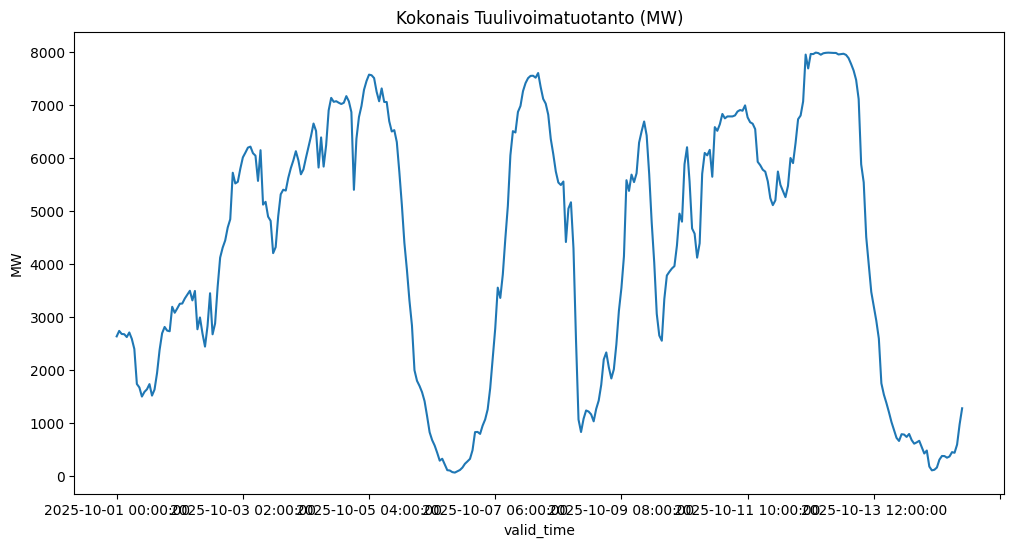

In [3]:
df_k['wind_speed'] = np.sqrt(df_k['u100']**2 + df_k['v100']**2)
df_k['roughness_length'] = 0.3

df_n['wind_speed'] = np.sqrt(df_n['u100']**2 + df_n['v100']**2)
df_n['roughness_length'] = 0.3

df_s['wind_speed'] = np.sqrt(df_s['u100']**2 + df_s['v100']**2)
df_s['roughness_length'] = 0.3

columns = pd.MultiIndex.from_tuples([
    ('wind_speed', 100),
    ('temperature', 2),
    ('pressure', 0),
    ('roughness_length', 0)
], names=['variable_name', 'height'])

weather_data_k = pd.DataFrame(index=df_k.index, columns=columns)
weather_data_n = pd.DataFrame(index=df_n.index, columns=columns)
weather_data_s = pd.DataFrame(index=df_s.index, columns=columns)

# Sijoitetaan data sarakkeisiin
weather_data_k[('wind_speed', 100)] = df_k['wind_speed']
weather_data_k[('temperature', 2)] = df_k['t2m']
weather_data_k[('pressure', 0)] = df_k['sp']
weather_data_k[('roughness_length', 0)] = df_k['roughness_length']

weather_data_n[('wind_speed', 100)] = df_n['wind_speed']
weather_data_n[('temperature', 2)] = df_n['t2m']
weather_data_n[('pressure', 0)] = df_n['sp']
weather_data_n[('roughness_length', 0)] = df_n['roughness_length']

weather_data_s[('wind_speed', 100)] = df_s['wind_speed']
weather_data_s[('temperature', 2)] = df_s['t2m']
weather_data_s[('pressure', 0)] = df_s['sp']
weather_data_s[('roughness_length', 0)] = df_s['roughness_length']


kalajoki_turbine = WindTurbine(
    hub_height=145,           # Realistinen keskiarvo Kalajoelle
    turbine_type='V126/3450'  # 4.2 MW versio on yleinen
)

narpio_turbine = WindTurbine(
    hub_height=155,           # Uudet puistot ovat korkeita (data mediaani 148m, uudet korkeampia)
    turbine_type='V126/3450'  # Tai 'N131/3000' jos N149 puuttuu. Tavoite: Iso roottori!
)

simo_turbine = WindTurbine(
    hub_height=135,           # Matalampi torni kuin uusissa puistoissa
    turbine_type='V126/3450'  # 3.45 MW klassikko
)


model_k = ModelChain(
    kalajoki_turbine, 
    wind_speed_model='logarithmic', # Hellman skaalaus 100m -> 165m
    density_correction=True,       # Huomioi kylmän ilman tiheyden!
    power_output_model='power_curve'
)

model_n = ModelChain(
    narpio_turbine, 
    wind_speed_model='logarithmic', # Hellman skaalaus 100m -> 165m
    density_correction=True,         # Huomioi kylmän ilman tiheyden!
    power_output_model='power_curve'
)

model_s = ModelChain(
    simo_turbine, 
    wind_speed_model='logarithmic', # Hellman skaalaus 100m -> 165m
    density_correction=True,         # Huomioi kylmän ilman tiheyden!
    power_output_model='power_curve'
)

model_k.run_model(weather_data_k)
kalajoki_total_mw = (model_k.power_output / 1000000) * 800 * 4.2 / 3.45

model_n.run_model(weather_data_n)
narpio_total_mw = (model_n.power_output / 1000000) * 600 * 5.7 / 3.45

model_s.run_model(weather_data_s)
simo_total_mw = (model_s.power_output / 1000000) * 350 * 1.0

total_mw = kalajoki_total_mw + narpio_total_mw + simo_total_mw

print("Kalajoen arvioitu tuotanto (MW):")
print(kalajoki_total_mw)
print("\nNarpion arvioitu tuotanto (MW):")
print(narpio_total_mw)
print("\nSimon arvioitu tuotanto (MW):")
print(simo_total_mw)
print("\nYhteensä arvioitu tuotanto (MW):")
print(total_mw)

total_mw.plot(title="Kokonais Tuulivoimatuotanto (MW)", ylabel="MW", figsize=(12, 6))
plt.ylabel("MW")
plt.show()

In [ ]:
df_hourly.plot(y='total_mw', title="Tuntikohtainen Tuulivoimatuotanto (MW)", figsize=(12, 6))
plt.ylabel("MW")
plt.show()

# Vertaus oikeisiin tuotantoarvoihin


In [4]:
df_fingrid = pd.read_csv("tuulivoima_oikea.csv", sep=';', decimal=',', parse_dates=['startTime'])
df_fingrid['startTime'] = pd.to_datetime(df_fingrid['startTime'])

df_fingrid.set_index('startTime', inplace=True)
df_fingrid['value'] = pd.to_numeric(df_fingrid['value'].astype(str).str.replace(',', '.'), errors='coerce')
df_hourly = df_fingrid['value'].resample('1h').mean()
df_hourly = df_hourly.reset_index()
df_hourly.head()
#df_fingrid.head()

,startTime,value
0,2025-09-30 21:00:00+00:00,3295.8200
1,2025-09-30 22:00:00+00:00,3224.7875
2,2025-09-30 23:00:00+00:00,3202.9075
3,2025-10-01 00:00:00+00:00,3122.0200
4,2025-10-01 01:00:00+00:00,3087.3475


In [11]:
total_mw_df = total_mw.to_frame(name='mw')
df_hourly.columns = ['aika', 'mw']

if 'aika' in df_hourly.columns:
    df_hourly = df_hourly.set_index('aika')

# Yhdistetään (inner join varmistaa, että otetaan vain ajat jotka löytyvät molemmista)
comparison_df = total_mw_df.join(df_hourly['mw'], how='inner')

print(comparison_df.head())

# 4. Nyt voit laskea korrelaation
correlation = comparison_df['mw'].corr(comparison_df['mw'])
print(f"Korrelaatio: {correlation}")

ValueError: columns overlap but no suffix specified: Index(['mw'], dtype='str')

In [10]:
total_mw_df.head()

,mw
valid_time,
2025-10-01 00:00:00,2631.072978
2025-10-01 01:00:00,2734.366931
2025-10-01 02:00:00,2676.040804
2025-10-01 03:00:00,2672.034347
2025-10-01 04:00:00,2618.284041


In [27]:
df_hourly.head()

,aika,mw
0,2025-09-30 21:00:00+00:00,3295.8200
1,2025-09-30 22:00:00+00:00,3224.7875
2,2025-09-30 23:00:00+00:00,3202.9075
3,2025-10-01 00:00:00+00:00,3122.0200
4,2025-10-01 01:00:00+00:00,3087.3475
